In [1]:
import os
import pandas as pd

In [2]:
fns = os.listdir('../processed_data/adj_expression/')

In [3]:
for i, f in enumerate(fns):
    df_exp = pd.read_csv('../processed_data/adj_expression/' + f, index_col=0, nrows = 5)
    if i == 0:
        s0 = set(map(str, df_exp.columns))
    else:
        s0 = s0 & set(map(str, df_exp.columns))

In [4]:
len(s0)

15744

In [5]:
id2gene = [str(s) for s in df_exp.columns if s in s0]

In [6]:
data = []
id2tissue = []
for i, f in enumerate(fns):
    tissue = f.split('-')[0]
    df_exp = pd.read_csv('../processed_data/adj_expression/' + f, index_col=0)
    df_exp = df_exp[id2gene]
    data.append(df_exp.values)
    id2tissue += [tissue] * df_exp.shape[0]

In [7]:
len(id2tissue)

7051

In [8]:
import numpy as np
data = np.vstack(data)

In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import tensorflow as tf


In [10]:
def DNN(x, theta_mat, is_train, scope = 'linear', reuse = tf.AUTO_REUSE):
    h_in = x 
    with tf.variable_scope(scope, reuse=reuse):
        for i, n_node in enumerate(theta_mat):
            h_out = tf.layers.dense(h_in, n_node, name = 'h%02d/dense' % i, use_bias=False)
            h_in = tf.layers.batch_normalization(h_out, training=is_train, name = 'h%02d/batch_norm' % i)
            if (i > 0) and ((i+1) != len(theta_mat)):
                h_in = tf.layers.dropout(h_in, rate=0.5, training=is_train)
            h_in = tf.nn.relu(h_in)   
    return h_out

In [11]:
num_gene = len(id2gene)

In [106]:
beta1 = 0.9

with tf.device("/gpu:0"):
    tf.reset_default_graph()
    
    ##========================= define inputs ===========================##
    is_training = tf.placeholder(tf.bool, name = 'is_training')
    l1_penalty = tf.placeholder(tf.float32, name = 'is_training')
    
    inputs = tf.placeholder(tf.float32, [None, num_gene], 
                            name='inputs')

    theta_mat = [128, 1024, 1024, num_gene]
    
    logit_rec = DNN(inputs, theta_mat, is_training, scope = 'AE', reuse = False)

   
    
    rec_loss = tf.reduce_mean(tf.abs(logit_rec - inputs))
    
    d_loss = rec_loss
    for v in tf.contrib.framework.get_variables_to_restore(include=['AE/h00/dense']): 
        if 'dense' not in v.name:
             continue
        
        print v.name
        d_loss += l1_penalty * tf.reduce_sum(np.abs(v))  
        


    d_lrd = tf.placeholder(tf.float32, name = 'd_lrd')
    
    d_optim = tf.train.AdamOptimizer(d_lrd, beta1=beta1)                  
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_train_op = d_optim.minimize(d_loss)


AE/h00/dense/kernel:0


In [107]:
sess = tf.Session()

In [14]:
num_sample = data.shape[0]

ind_train = np.array([i for i in range(num_sample) if i % 20 != 0])
ind_test = np.array([i for i in range(num_sample) if i % 20 == 0])

train_data = data[ind_train, :]
test_data = data[ind_test, :]

num_sample = train_data.shape[0]

In [110]:
sess.run(tf.global_variables_initializer())

In [111]:
iter_counter = 0
errD, errG, D_count, G_count = 0.0, 0.0, 0.0, 0.0

num_batch = 32

for idx in range(100000):
    lrd = 1e-4 / np.sqrt(idx * 0.01 + 1.0)
    l1_val = 0.001
    #l1_val = 0.001 * (1.0 + float(idx // 10000))
    
    batch_ind = np.random.choice(num_sample, size=num_batch)
    batch_x = train_data[batch_ind].astype('float32')
        
        
    # updates the discriminator
    feed_dict={inputs: batch_x, 
               is_training:True,
               l1_penalty: l1_val,
               #noise_level: 0.05, 
               d_lrd: lrd,
                }
        
    val, _ = sess.run([rec_loss, d_train_op], feed_dict=feed_dict)
        
    errD += val
    D_count += 1.0
        
            
    if idx % 100 == 0:
        errD = errD / D_count

        feed_dict={inputs: test_data, 
               is_training:False,
               }            

        test_errD1 = sess.run(rec_loss, feed_dict=feed_dict)


        msr = "iter: %4d, train_loss: %.4f, test_loss: %.4f" \
            % (idx, errD,test_errD1)
        print(msr)
        errD, errG, D_count, G_count = 0.0, 0.0, 0.0, 0.0
            
        iter_counter += 1

iter:    0, train_loss: 0.8239, test_loss: 0.7865
iter:  100, train_loss: 0.8276, test_loss: 0.7847
iter:  200, train_loss: 0.8226, test_loss: 0.7852
iter:  300, train_loss: 0.8196, test_loss: 0.7855
iter:  400, train_loss: 0.8192, test_loss: 0.7853
iter:  500, train_loss: 0.8167, test_loss: 0.7851
iter:  600, train_loss: 0.8151, test_loss: 0.7846
iter:  700, train_loss: 0.8088, test_loss: 0.7841
iter:  800, train_loss: 0.8047, test_loss: 0.7839
iter:  900, train_loss: 0.8026, test_loss: 0.7836
iter: 1000, train_loss: 0.7991, test_loss: 0.7835
iter: 1100, train_loss: 0.7978, test_loss: 0.7834
iter: 1200, train_loss: 0.7970, test_loss: 0.7834
iter: 1300, train_loss: 0.7977, test_loss: 0.7833
iter: 1400, train_loss: 0.7959, test_loss: 0.7833
iter: 1500, train_loss: 0.7962, test_loss: 0.7831
iter: 1600, train_loss: 0.7955, test_loss: 0.7830
iter: 1700, train_loss: 0.7953, test_loss: 0.7831
iter: 1800, train_loss: 0.7941, test_loss: 0.7827
iter: 1900, train_loss: 0.7945, test_loss: 0.7828


iter: 16300, train_loss: 0.7789, test_loss: 0.7694
iter: 16400, train_loss: 0.7753, test_loss: 0.7704
iter: 16500, train_loss: 0.7782, test_loss: 0.7696
iter: 16600, train_loss: 0.7766, test_loss: 0.7695
iter: 16700, train_loss: 0.7781, test_loss: 0.7693
iter: 16800, train_loss: 0.7782, test_loss: 0.7691
iter: 16900, train_loss: 0.7776, test_loss: 0.7692
iter: 17000, train_loss: 0.7771, test_loss: 0.7700
iter: 17100, train_loss: 0.7771, test_loss: 0.7694
iter: 17200, train_loss: 0.7748, test_loss: 0.7693
iter: 17300, train_loss: 0.7758, test_loss: 0.7694
iter: 17400, train_loss: 0.7751, test_loss: 0.7691
iter: 17500, train_loss: 0.7759, test_loss: 0.7690
iter: 17600, train_loss: 0.7784, test_loss: 0.7686
iter: 17700, train_loss: 0.7775, test_loss: 0.7688
iter: 17800, train_loss: 0.7781, test_loss: 0.7693
iter: 17900, train_loss: 0.7784, test_loss: 0.7682
iter: 18000, train_loss: 0.7770, test_loss: 0.7684
iter: 18100, train_loss: 0.7757, test_loss: 0.7689
iter: 18200, train_loss: 0.7766

iter: 32400, train_loss: 0.7704, test_loss: 0.7632
iter: 32500, train_loss: 0.7684, test_loss: 0.7629
iter: 32600, train_loss: 0.7698, test_loss: 0.7630
iter: 32700, train_loss: 0.7704, test_loss: 0.7628
iter: 32800, train_loss: 0.7677, test_loss: 0.7628
iter: 32900, train_loss: 0.7692, test_loss: 0.7629
iter: 33000, train_loss: 0.7689, test_loss: 0.7626
iter: 33100, train_loss: 0.7702, test_loss: 0.7624
iter: 33200, train_loss: 0.7688, test_loss: 0.7625
iter: 33300, train_loss: 0.7666, test_loss: 0.7625
iter: 33400, train_loss: 0.7708, test_loss: 0.7626
iter: 33500, train_loss: 0.7693, test_loss: 0.7625
iter: 33600, train_loss: 0.7678, test_loss: 0.7627
iter: 33700, train_loss: 0.7700, test_loss: 0.7624
iter: 33800, train_loss: 0.7684, test_loss: 0.7625
iter: 33900, train_loss: 0.7685, test_loss: 0.7625
iter: 34000, train_loss: 0.7687, test_loss: 0.7623
iter: 34100, train_loss: 0.7723, test_loss: 0.7623
iter: 34200, train_loss: 0.7679, test_loss: 0.7624
iter: 34300, train_loss: 0.7686

iter: 48500, train_loss: 0.7655, test_loss: 0.7586
iter: 48600, train_loss: 0.7631, test_loss: 0.7584
iter: 48700, train_loss: 0.7652, test_loss: 0.7583
iter: 48800, train_loss: 0.7625, test_loss: 0.7583
iter: 48900, train_loss: 0.7651, test_loss: 0.7584
iter: 49000, train_loss: 0.7634, test_loss: 0.7583
iter: 49100, train_loss: 0.7669, test_loss: 0.7583
iter: 49200, train_loss: 0.7631, test_loss: 0.7584
iter: 49300, train_loss: 0.7654, test_loss: 0.7584
iter: 49400, train_loss: 0.7655, test_loss: 0.7583
iter: 49500, train_loss: 0.7633, test_loss: 0.7582
iter: 49600, train_loss: 0.7628, test_loss: 0.7583
iter: 49700, train_loss: 0.7618, test_loss: 0.7582
iter: 49800, train_loss: 0.7627, test_loss: 0.7581
iter: 49900, train_loss: 0.7653, test_loss: 0.7582
iter: 50000, train_loss: 0.7643, test_loss: 0.7582
iter: 50100, train_loss: 0.7630, test_loss: 0.7582
iter: 50200, train_loss: 0.7652, test_loss: 0.7579
iter: 50300, train_loss: 0.7639, test_loss: 0.7580
iter: 50400, train_loss: 0.7625

iter: 64600, train_loss: 0.7615, test_loss: 0.7557
iter: 64700, train_loss: 0.7611, test_loss: 0.7557
iter: 64800, train_loss: 0.7602, test_loss: 0.7555
iter: 64900, train_loss: 0.7605, test_loss: 0.7554
iter: 65000, train_loss: 0.7610, test_loss: 0.7554
iter: 65100, train_loss: 0.7607, test_loss: 0.7556
iter: 65200, train_loss: 0.7607, test_loss: 0.7554
iter: 65300, train_loss: 0.7591, test_loss: 0.7554
iter: 65400, train_loss: 0.7584, test_loss: 0.7554
iter: 65500, train_loss: 0.7614, test_loss: 0.7554
iter: 65600, train_loss: 0.7591, test_loss: 0.7556
iter: 65700, train_loss: 0.7598, test_loss: 0.7554
iter: 65800, train_loss: 0.7605, test_loss: 0.7553
iter: 65900, train_loss: 0.7581, test_loss: 0.7556
iter: 66000, train_loss: 0.7589, test_loss: 0.7555
iter: 66100, train_loss: 0.7587, test_loss: 0.7553
iter: 66200, train_loss: 0.7612, test_loss: 0.7554
iter: 66300, train_loss: 0.7587, test_loss: 0.7552
iter: 66400, train_loss: 0.7569, test_loss: 0.7553
iter: 66500, train_loss: 0.7593

iter: 80700, train_loss: 0.7563, test_loss: 0.7535
iter: 80800, train_loss: 0.7586, test_loss: 0.7535
iter: 80900, train_loss: 0.7573, test_loss: 0.7535
iter: 81000, train_loss: 0.7584, test_loss: 0.7533
iter: 81100, train_loss: 0.7550, test_loss: 0.7534
iter: 81200, train_loss: 0.7556, test_loss: 0.7534
iter: 81300, train_loss: 0.7570, test_loss: 0.7533
iter: 81400, train_loss: 0.7572, test_loss: 0.7535
iter: 81500, train_loss: 0.7571, test_loss: 0.7534
iter: 81600, train_loss: 0.7560, test_loss: 0.7534
iter: 81700, train_loss: 0.7564, test_loss: 0.7533
iter: 81800, train_loss: 0.7575, test_loss: 0.7531
iter: 81900, train_loss: 0.7557, test_loss: 0.7532
iter: 82000, train_loss: 0.7568, test_loss: 0.7532
iter: 82100, train_loss: 0.7551, test_loss: 0.7532
iter: 82200, train_loss: 0.7575, test_loss: 0.7532
iter: 82300, train_loss: 0.7567, test_loss: 0.7533
iter: 82400, train_loss: 0.7556, test_loss: 0.7533
iter: 82500, train_loss: 0.7587, test_loss: 0.7533
iter: 82600, train_loss: 0.7560

iter: 96800, train_loss: 0.7528, test_loss: 0.7515
iter: 96900, train_loss: 0.7536, test_loss: 0.7517
iter: 97000, train_loss: 0.7534, test_loss: 0.7516
iter: 97100, train_loss: 0.7538, test_loss: 0.7515
iter: 97200, train_loss: 0.7536, test_loss: 0.7515
iter: 97300, train_loss: 0.7528, test_loss: 0.7514
iter: 97400, train_loss: 0.7540, test_loss: 0.7515
iter: 97500, train_loss: 0.7536, test_loss: 0.7515
iter: 97600, train_loss: 0.7532, test_loss: 0.7517
iter: 97700, train_loss: 0.7540, test_loss: 0.7515
iter: 97800, train_loss: 0.7532, test_loss: 0.7515
iter: 97900, train_loss: 0.7547, test_loss: 0.7515
iter: 98000, train_loss: 0.7550, test_loss: 0.7514
iter: 98100, train_loss: 0.7556, test_loss: 0.7516
iter: 98200, train_loss: 0.7554, test_loss: 0.7515
iter: 98300, train_loss: 0.7529, test_loss: 0.7515
iter: 98400, train_loss: 0.7541, test_loss: 0.7514
iter: 98500, train_loss: 0.7531, test_loss: 0.7515
iter: 98600, train_loss: 0.7536, test_loss: 0.7513
iter: 98700, train_loss: 0.7520

In [112]:
l1_val

0.001

In [113]:
w0 = tf.contrib.framework.get_variables_to_restore(include=['AE/h00/dense'])[0]

In [114]:
w0_val = sess.run(w0)

In [115]:
np.sum(np.abs(w0_val) < 5e-7) / float(w0_val.size)

0.22967380430640244

In [116]:
np.mean(np.abs(w0_val))

9.4072675e-06

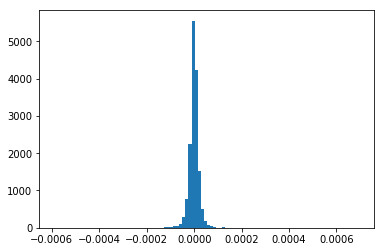

In [118]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.hist(w0_val[:, 38], bins = 100)
plt.show()

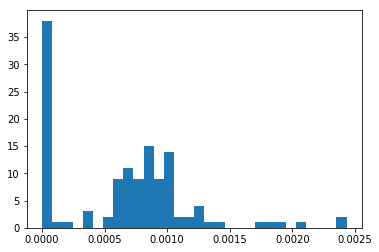

In [119]:
plt.hist([np.max(np.abs(w0_val[:, i])) for i in range(128)], bins = 30)
plt.show()

In [120]:
for i in range(1, 5):
    print i, np.sum(np.abs(w0_val[:, 0]) > (i * w0_val[:, 0].std()))

1 4403
2 835
3 156
4 30


In [81]:
for i in range(10):
    print np.where(np.abs(w0_val[:, i]) > (3.0 * w0_val[:, i].std()))[0]

[  733   752  1985  2183  2307  5182  6447  6706  7259  7286  7332  7377
  7388  7646  7764  7941  8161  8235  8522  9243  9710  9890 10176 10206
 10446 11879 12353 12592 14095 14994 15015]
[   82   124   265  1501  1548  2062  2108  3145  3227  4529  4586  4668
  4895  5592  5767  6944  7463  7728  7847  7954  8180  8471  8742  9091
 10367 10666 10724 11436 11706 12002 12258 12283 13024 13259 13566 14921
 15147]
[   62   230   347  1611  2070  2127  2486  3246  3584  3638  3734  4140
  5387  5474  6139  6374  7354  7561  7812  8221  8916  8943  9547  9589
  9957 11325 11349 11495 11938 12010 12826 12947 12964 13407 13766 14366
 14768]
[  122   382   633   909   924  1565  2499  2583  3463  3577  3836  4479
  4752  5580  5658  6041  6929  7327  7690  7818  8340  8394  8724  8866
  9034  9242  9279  9870  9873 10143 10512 10643 10749 12114 13102 13283
 13667 13776 15002 15063]
[   28    92   771   972   975   999  1234  1475  1619  1751  3385  3908
  4193  4403  4580  4858  4968  5249  

In [83]:
import pickle
with open('ensembl2genename.p', 'rb') as reader:
    gid2gn = pickle.load(reader)

In [130]:
for i in np.where(np.abs(w0_val[:, 53]) > (3.0 * w0_val[:, 53].std()))[0]:
    gid = id2gene[i].split('.')[0]
    if gid in gid2gn:
        print gid2gn[gid]
    else:
        print gid

DNAJC11
PARK7
MTOR
AGTRAP
DNAJC8
CC2D1B
ENSG00000270172
DBT
ENSG00000223804
ENSG00000196369
SLC39A1
CREB3L4
FAM189B
ENSG00000203739
KLHL20
TOR1AIP2
ZNF281
MDM4
EIF2D
TSNAX
ZMYND11
AGAP6
HERC4
ATAD1
ENSG00000155640
RRP12
ENSG00000224934
CHUK
NDUFB8
VTI1A
FAM204A
TRIM44
RTN3
ANAPC15
C2CD3
ATP5L
ITFG2
TUBA1A
COX14
PFDN5
RAB5B
NACA
CHST11
MAPKAPK5
DDX51
SAP18
MTMR6
RASL11A
PAN3
SLC25A30
SUGT1
PPP1R3E
ENSG00000271424
JKAMP
SETD3
ENSG00000271780
DYNC1H1
EIF5
DPP8
RPL4
ENSG00000259781
ENSG00000250988
GLYR1
NPIPA3
DCTN5
CDIPT
PHKG2
FAM192A
COQ9
POLR2C
PSMB10
KARS
COX4I1
MED11
SLC16A13
KDM6B
CDRT4
SMCR8
ERAL1
ENSG00000178082
RPL19
MLX
BECN1
AARSD1
ARL4D
DHX8
GPATCH8
SP2
ATP5G1
SNF8
PSMC5
ENSG00000214176
PCYT2
ENSG00000257267
NARS
IZUMO4
PPAN
ZNF540
NUMBL
TOMM40
CLASRP
SNRNP70
RNASEH1
RPS7
AFTPH
ACTR2
NFU1
RNF103
COX5B
ENSG00000240356
ATG9A
CDK5RAP1
STAU1
RTFDC1
ENSG00000232442
SCAF4
PEX26
UFD1L
SNRPD3
EWSR1
EIF4ENIF1
RP1-37E16.12
L3MBTL2
SEC13
DPH3
POMGNT2
DCAF1
PDE12
ATXN7
FRMD4B
HCLS1
ATP2C1


In [97]:
for i in np.where(np.abs(w0_val[:, 138]) > (3.0 * w0_val[:, 138].std()))[0]:
    gid = id2gene[i].split('.')[0]
    if gid in gid2gn:
        print gid2gn[gid]
    else:
        print gid

NMNAT1
SRM
HSPB7
STX12
ZMYM1
SLC30A7
AMPD2
MRPL9
ACBD6
ADORA1
TMEM81
KCNK1
FAM21EP
ENTPD1
TSPAN4
TPP1
ENSG00000243964
MICAL2
ENSG00000214391
ENSG00000256745
BIRC2
CBL
ENSG00000269892
RPAP3
KMT2D
ENSG00000240342
ENSG00000179611
RASA3
AKAP5
EFCAB11
DAPK2
EFL1
ENSG00000260565
ENSG00000262468
MAPK3
FBXL19-AS1
CES3
PLEKHG4
ENSG00000262692
KIF1C
ATP1B2
SLC46A1
KIAA0100
ENSG00000266947
DCAF7
PITPNC1
TGIF1
APCDD1
C18orf54
PQLC1
DOT1L
CACTIN
ENSG00000269131
LRFN1
LYPD3
YPEL5
ENSG00000231609
MXD1
ANKRD53
POLR1A
ENSG00000214199
ENSG00000265451
MYO1B
RNF24
ENSG00000233578
C20orf196
HIC2
TTC28
ASB14
NSUN3
ATP6V1A
TPRA1
ENSG00000273486
SKIL
TMEM175
AIMP1
BBS7
GUCY1B3
CDKN2AIP
FAM149A
MAP1B
MSH3
ENSG00000271849
KIF3A
ZSCAN31
TAF11
TREM2
ENSG00000232699
BEND3
ENSG00000272403
ARMT1
FAM221A
EEPD1
CDK14
LAMTOR4
SYPL1
CCDC71L
ENSG00000273329
BRAF
ACTR3C
SFRP1
ENSG00000253704
MTERF3
ENSG00000188686
PUM3
ENSG00000186940
GOLGA2
POMT1
NPDC1
TSPAN7
ENSG00000086758
ENSG00000271533
ENSG00000077721


In [88]:
gid2gn

{'ENSG00000180008': u'SOCS4',
 'ENSG00000124209': u'RAB22A',
 'ENSG00000064703': u'DDX20',
 'ENSG00000230873': u'STMND1',
 'ENSG00000171408': u'PDE7B',
 'ENSG00000243772': u'KIR2DL3',
 'ENSG00000160161': u'CILP2',
 'ENSG00000110514': u'MADD',
 'ENSG00000247077': u'PGAM5',
 'ENSG00000091622': u'PITPNM3',
 'ENSG00000076864': u'RAP1GAP',
 'ENSG00000086015': u'MAST2',
 'ENSG00000112499': u'SLC22A2',
 'ENSG00000168032': u'ENTPD3',
 'ENSG00000167747': u'C19orf48',
 'ENSG00000168036': u'CTNNB1',
 'ENSG00000167740': u'CYB5D2',
 'ENSG00000168038': u'ULK4',
 'ENSG00000167749': u'KLK4',
 'ENSG00000167748': u'KLK1',
 'ENSG00000240764': u'PCDHGC5',
 'ENSG00000124201': u'ZNFX1',
 'ENSG00000231690': u'LINC00574',
 'ENSG00000152556': u'PFKM',
 'ENSG00000213995': u'NAXD',
 'ENSG00000087494': u'PTHLH',
 'ENSG00000087495': u'PHACTR3',
 'ENSG00000219545': u'UMAD1',
 'ENSG00000169740': u'ZNF32',
 'ENSG00000261609': u'GAN',
 'ENSG00000169744': u'LDB2',
 'ENSG00000215644': u'GCGR',
 'ENSG00000177565': u'TBL1